In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import idx2numpy

#### 1. Preparamos los datos disponibles como dos datasets de imágenes
- tr_dataset: 60k imágenes para entrenar el modelo
- ts_dataset: 10k imágenes para testar el modelo

In [49]:
# Datos para entrenamiento
tr_imagefile = './data/MNIST/raw/train-images-idx3-ubyte'
tr_labelfile = './data/MNIST/raw/train-labels-idx1-ubyte'

# Datos de test
ts_imagefile = './data/MNIST/raw/t10k-images-idx3-ubyte'
ts_labelfile = './data/MNIST/raw/t10k-labels-idx1-ubyte'

In [50]:
# creamos los datasets a partir de los ficheros descargados previamente
class MiDataset(Dataset):
    def __init__(self, imagefile, labelfile, transform = transforms.ToTensor()):
        self.imagearray = idx2numpy.convert_from_file(imagefile)
        self.labelarray = idx2numpy.convert_from_file(labelfile)
        self.transform = transform  

    def __len__(self):
        return len(self.labelarray)

    def __getitem__(self, idx):
        image = self.imagearray[idx]
        label = self.labelarray[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
# Crea los datasets de tr y ts
tr_dataset = MiDataset(tr_imagefile, tr_labelfile)
ts_dataset = MiDataset(ts_imagefile, ts_labelfile)

#### 2. Preparamos los cargadores para acceder realmente a los datos

In [51]:
# crea los cargadores de datos
num_lotes = 100
train_loader = torch.utils.data.DataLoader(dataset=tr_dataset, 
                                           batch_size = num_lotes,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=ts_dataset, 
                                           batch_size = num_lotes,
                                           shuffle = False)

Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


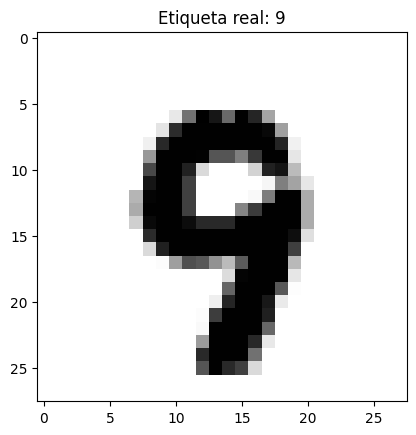

In [52]:
# prueba que está todo ok
train_imgs, train_labels = next(iter(train_loader))
print(f"Tensor con el lote: {train_imgs.size()}")
print(f"Nº etiquetas del lote: {train_labels.size()}")

img_prueba = train_imgs[0].squeeze()
label_img_prueba = train_labels[0]

fig = plt.figure(1,figsize=(2, 2))
plt.imshow(img_prueba, cmap=plt.cm.gray)
plt.title(f'ETIQUETA REAL: {label_img_prueba}')
plt.show()

#### 3 Definimos la CNN

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            #nn.MaxPool2d((2, 2)),
            nn.Flatten(),
            nn.Linear(64*14*14, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        out = self.main(x)
        return out
    
model = CNN()
model

CNN(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12544, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=10, bias=True)
  )
)

from torchinfo import summary

summary(model, (1, 28, 28))

In [34]:
# Prueba modelo bien definido
model(train_imgs[range(2)] )

tensor([[-0.0052,  0.0405,  0.0229, -0.0761,  0.0130,  0.0083, -0.0334, -0.0588,
         -0.0414, -0.0895],
        [ 0.0038,  0.0495,  0.0345, -0.0595,  0.0152, -0.0002, -0.0459, -0.0635,
         -0.0363, -0.1064]], grad_fn=<AddmmBackward0>)

#### 4. Realizamos el entrenamiento del modelo

In [35]:
# CPU o GPU
device = torch.device('cpu')

# función de pérdida, ratio de aprendizaje y optimizador
funcion_perdida = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizador = torch.optim.Adam(model.parameters(), lr = learning_rate)

# nº de épocas
n_epochs = 2

In [36]:
# Bucle de ajuste de los parámetros del modelo
n_total_steps = len(train_loader)
tr_eval_loss = np.zeros(n_epochs * n_total_steps)

k=0
for epoch in range(n_epochs):
    for i, (imgs, etqs) in enumerate(train_loader):
        imgs = imgs.to(device)
        etqs = etqs.to(device)
        
        # forward
        outputs = model(imgs)
        loss = funcion_perdida(outputs, etqs)
        tr_eval_loss[k] = loss
        k+=1

        # backwards
        optimizador.zero_grad()
        loss.backward()
        optimizador.step()

        if (i+1) % 100 == 0:
            print(f'Época: {epoch+1}/{n_total_steps} '
                  f' - Paso: {i+1}/{n_total_steps} :: loss = {loss.item()}')


Época: 1/600  - Paso: 100/600 :: loss = 0.211585134267807
Época: 1/600  - Paso: 200/600 :: loss = 0.1751089245080948
Época: 1/600  - Paso: 300/600 :: loss = 0.12613032758235931
Época: 1/600  - Paso: 400/600 :: loss = 0.04149782657623291
Época: 1/600  - Paso: 500/600 :: loss = 0.11972083151340485
Época: 1/600  - Paso: 600/600 :: loss = 0.05309676751494408
Época: 2/600  - Paso: 100/600 :: loss = 0.05005462095141411
Época: 2/600  - Paso: 200/600 :: loss = 0.14812569320201874
Época: 2/600  - Paso: 300/600 :: loss = 0.12674489617347717
Época: 2/600  - Paso: 400/600 :: loss = 0.04822380095720291
Época: 2/600  - Paso: 500/600 :: loss = 0.0875895768404007
Época: 2/600  - Paso: 600/600 :: loss = 0.02123689092695713


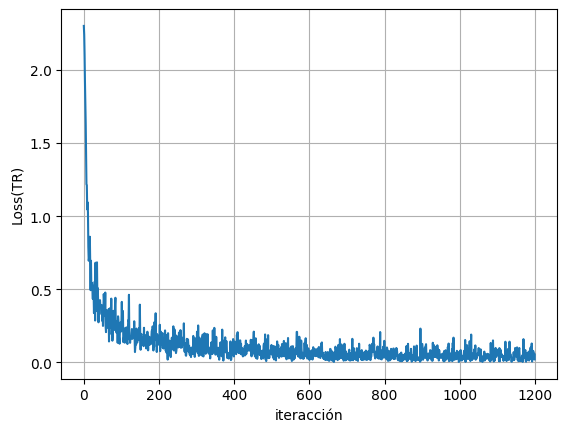

In [37]:
plt.plot(tr_eval_loss)
plt.xlabel('iteracción')
plt.ylabel('Loss(TR)')
plt.grid()
plt.show()


In [38]:
# Guardamos el modelo para poderlo utilizar luego
nombre_fi_modelo = f'modelo_cnn_ajustado_{n_epochs}_epocas.pth'
torch.save(model.state_dict(), nombre_fi_modelo)
print(f'Modelo guardado como {nombre_fi_modelo}')

Modelo guardado como modelo_cnn_ajustado_2_epocas.pth


In [39]:

# entrenamiento
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for imgs, etqs in train_loader:
        imgs = imgs.to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)

        _, predictions = torch.max(outputs, 1)
        n_samples += etqs.shape[0] 
        n_correct += (predictions == etqs).sum().item()

    acc = 100.0 * n_correct / n_samples
    n_incorrect = n_samples - n_correct

    print(f'Correctas:{n_correct} Incorrectas:{n_incorrect}')
    print(f'Aciertos TR: {acc}')


# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for imgs, etqs in test_loader:
        imgs = imgs.to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)

        _, predictions = torch.max(outputs, 1)
        n_samples += etqs.shape[0] 
        n_correct += (predictions == etqs).sum().item()

    acc = 100.0 * n_correct / n_samples
    n_incorrect = n_samples - n_correct

    print(f'Correctas:{n_correct} Incorrectas:{n_incorrect}')
    print(f'Aciertos TS: {acc}')


Correctas:59509 Incorrectas:491
Aciertos TR: 99.18166666666667
Correctas:9878 Incorrectas:122
Aciertos TS: 98.78


122.0


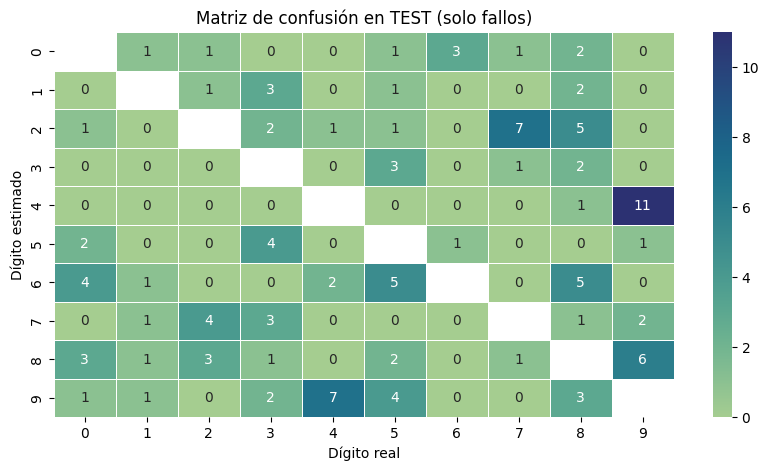

In [40]:
# matriz de confusión TEST
confusion_matrix = torch.zeros(10, 10, dtype=float)
with torch.no_grad():
    for i, (imgs, etqs) in enumerate(test_loader):
        imgs = imgs.to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)
        _, predictions = torch.max(outputs, 1)

        for t, p in zip(etqs.view(-1), predictions.view(-1)):
            confusion_matrix[p.long(), t.long()] += 1

# eliminamos los aciertos para facilitar el foco en los errores de clasificación
confusion_matrix[confusion_matrix>100] = float("nan")

print(confusion_matrix.nansum().item())

# representamos para facilitar el análisis
fig = plt.figure(1,figsize=(10, 5))
sns.heatmap(confusion_matrix, annot=True, linewidth=.5,  cmap="crest")
plt.title('Matriz de confusión en TEST (solo fallos)')
plt.xlabel('Dígito real')
plt.ylabel('Dígito estimado')
plt.show()

¿Por qué ha fallado?

In [41]:
# guardamos en un nuevo tensor todos los casos incorrectos
tr_err_img = torch.empty(1, 1, 28, 28, dtype=float)
tr_err_etq_real = torch.empty(1, 1, dtype=torch.uint8)
tr_err_etq_est = torch.empty(1, 1, dtype=torch.uint8)

with torch.no_grad():
    for i, (imgs, etqs) in enumerate(test_loader):
        imgs = imgs.to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)
        _, predictions = torch.max(outputs, 1)

        # cogemos los fallos
        ind_fallos = etqs != predictions

        tr_err_img = torch.cat((tr_err_img, imgs[ind_fallos]), dim=0)
        tr_err_etq_real = torch.cat((tr_err_etq_real, etqs[ind_fallos].unsqueeze(0)), dim=1)
        tr_err_etq_est = torch.cat((tr_err_etq_est, predictions[ind_fallos].unsqueeze(0)), dim=1)
        # print(tr_err_etq_real)
        # print(tr_err_etq_est)
        # print(tr_err_img)

print(tr_err_etq_real.size())
print(tr_err_etq_est.size())
print(tr_err_img.size())

torch.Size([1, 123])
torch.Size([1, 123])
torch.Size([123, 1, 28, 28])


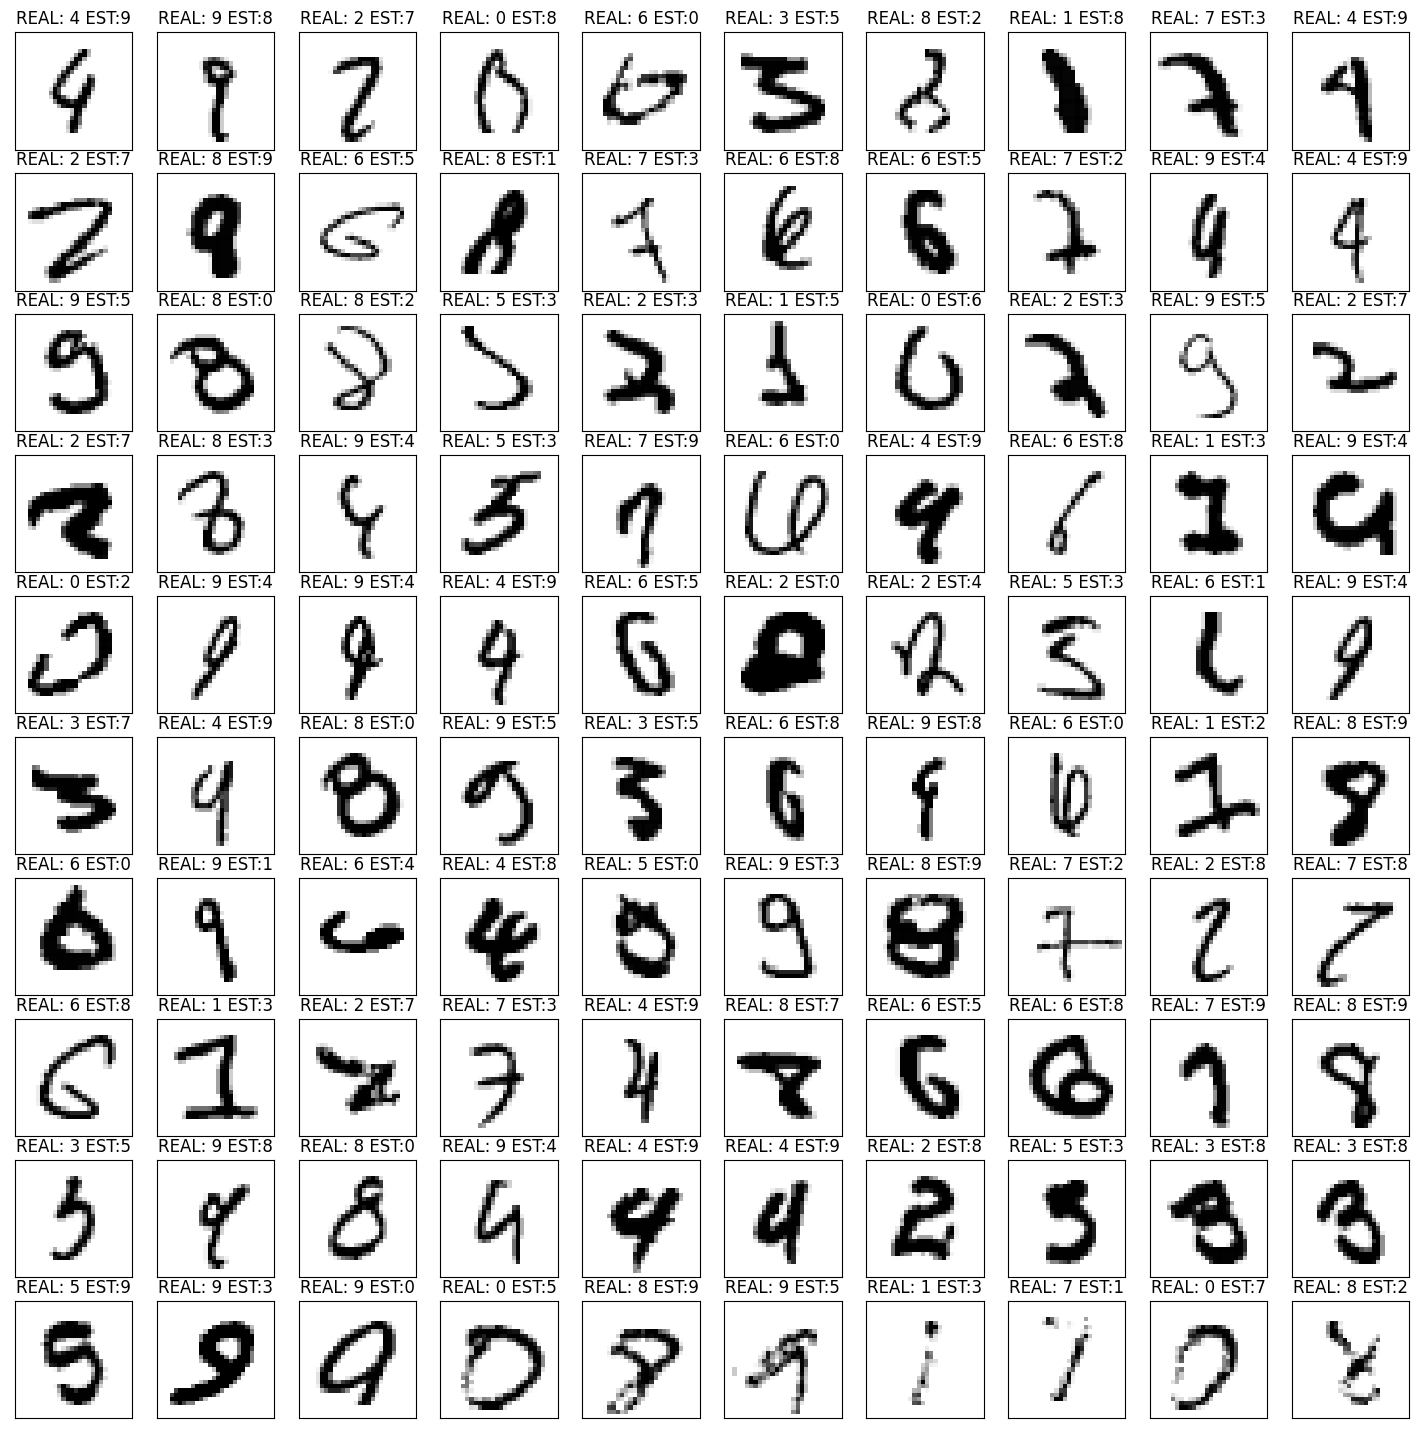

In [42]:
# pintamos unos cuantos fallos
fig = plt.figure(1,figsize=(18, 18))
k=1
for i in range(100):
    plt.subplot(10,10,k)
    plt.imshow(tr_err_img[i+1].reshape(28,28), cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'REAL: {tr_err_etq_real[0,i+1].item()} EST:{tr_err_etq_est[0,i+1].item()}')
    k = k+1

plt.show()

filtros estimados (kernels)

In [43]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
main.0.weight 	 torch.Size([32, 1, 3, 3])
main.0.bias 	 torch.Size([32])
main.3.weight 	 torch.Size([64, 32, 3, 3])
main.3.bias 	 torch.Size([64])
main.6.weight 	 torch.Size([100, 12544])
main.6.bias 	 torch.Size([100])
main.8.weight 	 torch.Size([10, 100])
main.8.bias 	 torch.Size([10])


In [44]:
model.eval()

CNN(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12544, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=10, bias=True)
  )
)

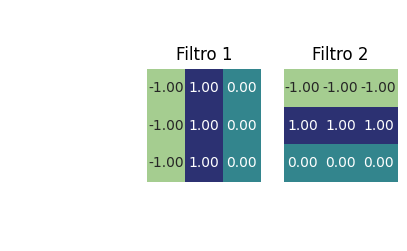

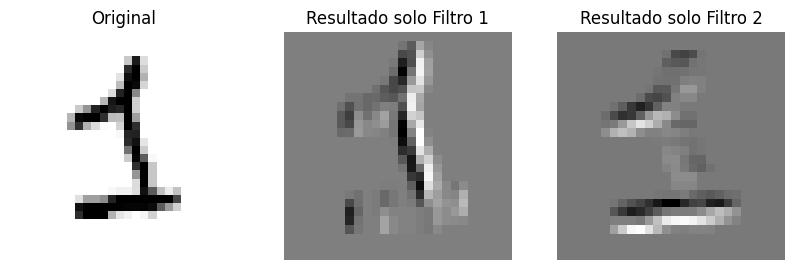

In [45]:
# 1 kernel of (3,3)
img_prueba = train_features[9].squeeze()

filter_1 = torch.tensor([[[[  -1.,   1.,  0.],
                           [  -1.,   1.,  0.],
                           [  -1.,   1.,  0.]]]])

filter_2 = torch.tensor([[[[ -1.,  -1., -1.],
                           [  1.,   1.,  1.],
                           [  0.,   0.,  0.]]]])

with torch.no_grad():
    conv_layer_aux = torch.nn.Conv2d(1, 1, kernel_size=(3, 3))
    conv_layer_aux.weight[0] = filter_1
    filtered_image_1 = conv_layer_aux(img_prueba[None, None, :])
    conv_layer_aux.weight[0] = filter_2
    filtered_image_2 = conv_layer_aux(img_prueba[None, None, :])

fig = plt.figure(1,figsize=(5, 3))
plt.subplot(1,3,1)
plt.axis('off')
plt.subplot(1,3,2)
sns.heatmap(filter_1.detach().squeeze(), annot=True, square=True, annot_kws={"fontsize":10}, cmap='crest', fmt='1.2f', cbar=False)
plt.title(f'Filtro 1')
plt.axis('off')
plt.subplot(1,3,3)
sns.heatmap(filter_2.detach().squeeze(), annot=True, square=True, annot_kws={"fontsize":10}, cmap='crest', fmt='1.2f', cbar=False)
plt.title(f'Filtro 2')
plt.axis('off')
plt.show()

fig = plt.figure(2,figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(img_prueba, cmap=plt.cm.binary)
plt.title(f'Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(filtered_image_1.detach().squeeze(), cmap=plt.cm.binary)
plt.title(f'Resultado solo Filtro 1')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(filtered_image_2.detach().squeeze(), cmap=plt.cm.binary)
plt.title(f'Resultado solo Filtro 2')
plt.axis('off')
plt.show()

Miramos la pinta de los filtros

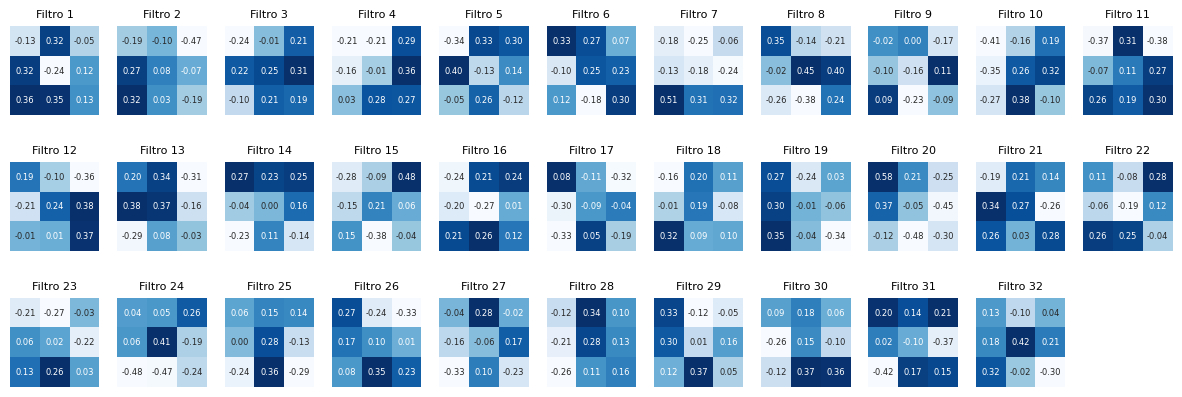

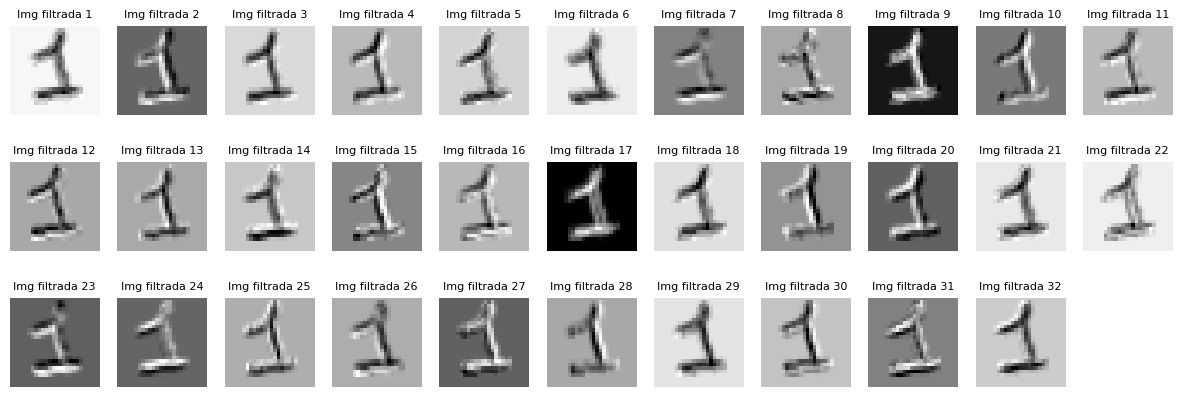

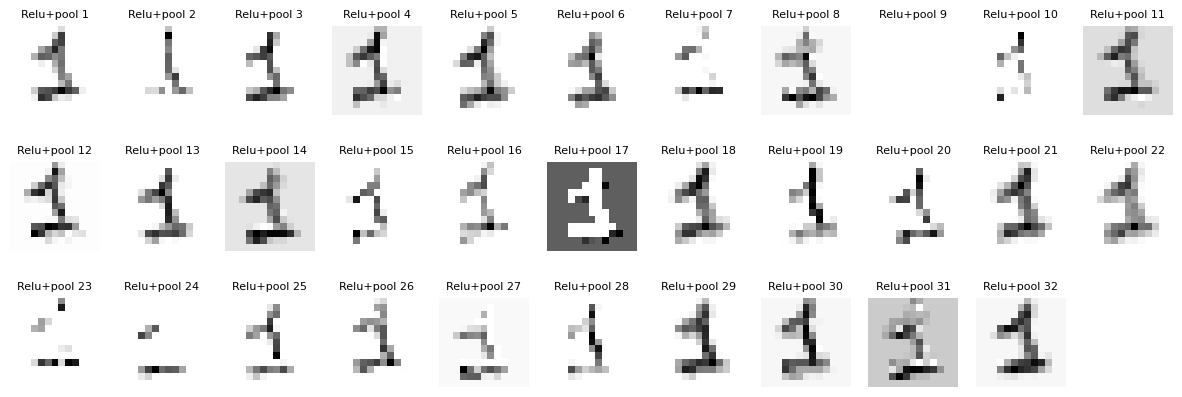

In [46]:
import seaborn as sns

img_prueba = train_features[9].squeeze()

fig = plt.figure(1,figsize=(15, 5))

for f in range(32):
    plt.subplot(3,11,f+1)
    filtro = model.main[0].weight[f]
    sns.heatmap(filtro.detach().squeeze(), annot=True, square=True, annot_kws={"fontsize":6}, cmap='Blues', fmt='1.2f', cbar=False)
    plt.title(f'Filtro {f+1}', fontdict={'size': 8})
    plt.axis('off')
plt.show()

fig = plt.figure(2,figsize=(15, 5))
for f in range(32):
    with torch.no_grad():
        conv_layer_aux = nn.Conv2d(1, 1, kernel_size=(3, 3))
        conv_layer_aux.weight[0] = model.main[0].weight[f]
        filtered_image = conv_layer_aux(img_prueba[None, None, :])

    plt.subplot(3,11,f+1)
    plt.imshow(filtered_image.squeeze(), cmap=plt.cm.binary)
    plt.title(f'Img filtrada {f+1}', fontdict={'size': 8})
    plt.axis('off')
plt.show()

fig = plt.figure(3,figsize=(15, 5))
for f in range(32):
    with torch.no_grad():
        conv_layer_aux = nn.Conv2d(1, 1, kernel_size=(3, 3))
        conv_layer_aux.weight[0] = model.main[0].weight[f]
        filtered_image_relu_pool = nn.functional.max_pool2d(nn.functional.relu(conv_layer_aux(img_prueba[None, None, :])),(2,2))

    plt.subplot(3,11,f+1)
    plt.imshow(filtered_image_relu_pool.squeeze(), cmap=plt.cm.binary)
    plt.title(f'Relu+pool {f+1}', fontdict={'size': 8})
    plt.axis('off')
plt.show()